In [1]:
from matplotlib import pyplot as plt
from numcodecs import Blosc, Delta
import os
import numpy as np
from poisson_numcodecs import Poisson
from poisson_numcodecs import estimate
import zarr

### Load example data and estimate `zero_level` and `photon_sensitivity` 

In [2]:
data = np.load('../tests/data/data1.npz')['data']

In [3]:
# for bright images use count_weight_gamma=1
# for photon-starved images with few cells use count_weight_gamma = 0.001
# Otherwise, use the default

qs = estimate.compute_sensitivity(
    data.transpose(1,2,0),   # time must be in the third dimensions
    count_weight_gamma=1)  

In [4]:
qs

{'model': HuberRegressor(),
 'counts': array([605, 679, 675, ...,  27,  20,  26]),
 'min_intensity': 90,
 'max_intensity': 3016,
 'variance': array([  5706.29669421,   5897.68851252,   5368.22962963, ...,
        250302.94444444, 566103.325     , 584751.57692308]),
 'sensitivity': 96.99485239520567,
 'zero_level': 86.30213578612849}

The slope and x-intercept for the photon transfer curve yield the photon sensitivity and the zero level.

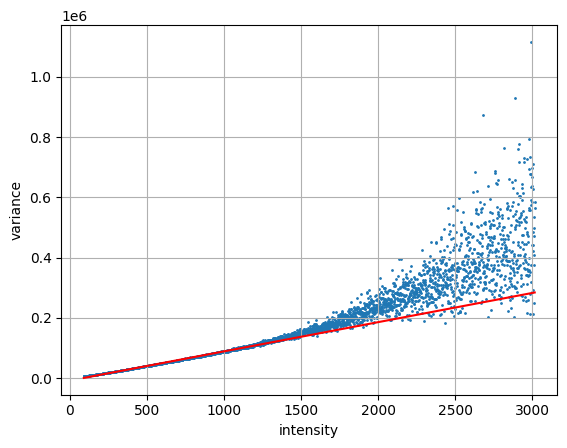

In [5]:
intensity = np.r_[qs['min_intensity']:qs['max_intensity']]
sensitivity = qs['sensitivity']
zero_level = qs['zero_level']
plt.scatter(intensity, qs['variance'], s=1)
plt.plot(intensity, (intensity - zero_level) * sensitivity, 'r')
plt.grid(True)
plt.xlabel('intensity')
plt.ylabel('variance');

## Illustrate GIF compression
This does not use `zarr` and `numcodecs`

In [6]:
# make compression lookup tables
zero = np.int16(np.round(qs['zero_level']))
LUT1 = estimate.make_anscombe_lookup(sensitivity, input_max=data.max()-zero)
LUT2 = estimate.make_inverse_lookup(LUT1)

Text(0.5, 1.0, 'compression/decompression transform')

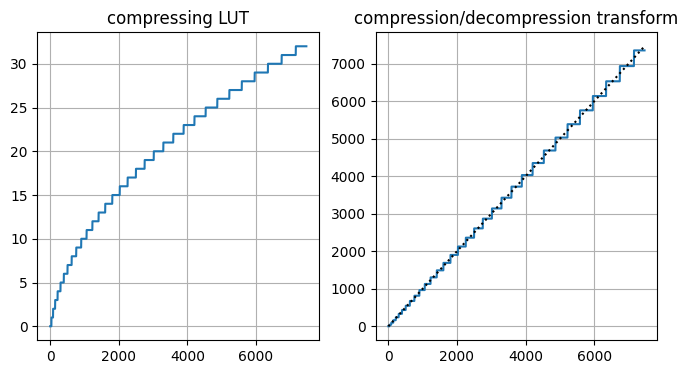

In [7]:
fig, axx = plt.subplots(1, 2, figsize=(8, 4))
axx = iter(axx.flatten())

ax = next(axx)
ax.plot(LUT1)
ax.grid(True)
ax.set_title('compressing LUT')

ax = next(axx)
ax.plot(LUT2[LUT1])
ax.plot(np.r_[:LUT1.size], np.r_[:LUT1.size], 'k:')
ax.grid(True)
ax.set_title('compression/decompression transform')

In [8]:
# save compressed video as .gif
compressed = estimate.lookup(data - zero, LUT1)
gif_path = 'test.gif'
scale = 255//np.max(compressed)  # this makes the gif brighter. Use scale=1 normally
estimate.save_movie(compressed, gif_path, scale=scale)          
print(f'Compression ratio: {np.prod(data.shape)*2 / os.path.getsize(gif_path):0.2f}')

Compression ratio: 3.61


You may open and view the saved `test.gif`

### Illustrate image compression using numcodecs / zarr

In [9]:
# instantiate Poisson object
poisson_filter = Poisson(zero_level, sensitivity)

In [10]:
z = zarr.open('zarr_array.zarr', shape=data.shape, dtype=data.dtype, filters=[poisson_filter], compressor=Blosc(cname='zstd', clevel=1))
z[...] = data

In [11]:
z.info

Type,zarr.core.Array
Data type,int16
Shape,"(300, 200, 200)"
Chunk shape,"(75, 50, 100)"
Order,C
Read-only,False
Filter [0],"Poisson(decoded_dtype='int16', encoded_dtype='int8', photon_sensitivity=96.99485239520567, zero_level=86.30213578612849)"
Compressor,"Blosc(cname='zstd', clevel=1, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,24000000 (22.9M)
No. bytes stored,5242634 (5.0M)


# RESTART THE KERNEL
Restart the kernel manually to test zarr loading

In [12]:
import matplotlib.pyplot as plt
import zarr
from poisson_numcodecs import Poisson

# you don't need to import poisson_numcodecs but it must be installed

In [13]:
# open zarr
z_reopened = zarr.open('zarr_array.zarr', mode='r')
z_reopened.info

Type,zarr.core.Array
Data type,int16
Shape,"(300, 200, 200)"
Chunk shape,"(75, 50, 100)"
Order,C
Read-only,True
Filter [0],"Poisson(decoded_dtype='int16', encoded_dtype='int8', photon_sensitivity=96.99485239520567, zero_level=86.30213578612849)"
Compressor,"Blosc(cname='zstd', clevel=1, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,24000000 (22.9M)
No. bytes stored,5242634 (5.0M)


(-0.5, 199.5, 199.5, -0.5)

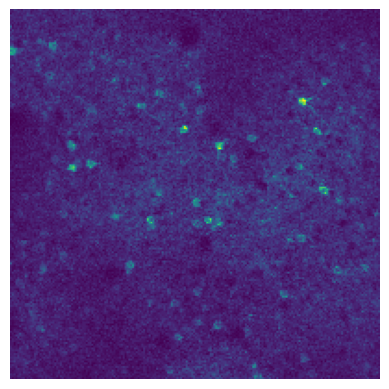

In [14]:
# show a decompressed frame
plt.imshow(z_reopened[10,:,:])
plt.axis(False)